In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from pandas.tools.plotting import scatter_matrix
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm

df = pd.read_csv('MuRun.csv')

#Make sure events are neutral
#if first event is positive and the second is negative
#or the second is positive and the first is negative
df1 = df[df.Q1 == 1]
df1 = df1[df1.Q2 == -1]

df2 = df[df.Q1 == -1]
df2 = df2[df2.Q2 == 1]

frames = [df1, df2]

df = pd.concat(frames)
df = df[np.sqrt(df.px1**2 + df.py1**2) + np.sqrt(df.px2**2 + df.py2**2) < 50]

df.head()

,Run,Event,Type1,E1,px1,py1,pz1,pt1,eta1,phi1,...,Type2,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
2,146436,90644850,G,12.39990,-0.849742,9.40110,8.04015,9.43943,0.772580,1.660940,...,G,8.55532,-4.851550,6.97696,-0.983229,8.49797,-0.115445,2.178410,-1,9.41149
4,146436,90686690,G,7.95664,7.097000,-1.31646,3.34613,7.21806,0.448399,-0.183411,...,T,5.44467,-1.341760,1.38647,5.090250,1.92941,1.697380,2.339810,-1,8.67727
5,146436,90692451,G,11.34150,0.816445,4.98596,10.15340,5.05236,1.447940,1.408490,...,G,7.86621,0.602823,5.05381,5.996810,5.08964,1.001970,1.452080,-1,2.30104
8,146436,90808356,G,8.99267,-1.644400,-4.20646,7.77551,4.51646,1.311720,-1.943450,...,G,6.45454,0.860784,-4.41161,4.631050,4.49480,0.902647,-1.378100,-1,3.13180
9,146436,90851884,G,10.41950,-3.619030,-2.36646,-9.47933,4.32406,-1.526440,-2.562490,...,G,25.64730,11.795100,-17.82190,14.178500,21.37160,0.622447,-0.986147,-1,28.36050


In [2]:
def poly(x, c1, c2, c3, c4):
    return c1*x*x*x + c2*x*x + c3*x + c4

def line(x, c1, c2):
    return c1*x + c2

def gaussian(x, mu, sig, const):
    return const * 1/(sig*np.sqrt(2*np.pi)) * np.exp(-(x - mu)**2 / 2*sig**2)

def gaus_poly(x, mu, sig, cont, c1, c2, c3, c4):
    return poly(x, c1, c2, c3, c4) + gaussian(x, mu, sig, cont)

def P_fac(Energy,Mass):
    m_mu = 0.105
    p = ((Energy**2.0/4.0)-m_mu**2.0)**(1.0/2.0)
    p0 = ((Mass**2.0/4.0)-m_mu**2.0)**(1.0/2.0)
    return (p/p0)**3.0

def BW_2(Energy,Mass,Gamma):
    g = ((Mass**2.0 + Gamma*P_fac(Energy,Mass)**2.0)*Mass**2.0)**(1.0/2.0)
    k = (2.0 * 2.0**(1.0/2.0) * Mass * Gamma*P_fac(Energy,Mass) * g)/(np.pi * (Mass**(2.0)+g)**(1.0/2.0))
    return (k/((Energy**2.0-Mass**2.0)**2.0 + (Gamma*P_fac(Energy,Mass)*Mass)**2.0))

def BW(Energy,Mass,Gamma):
    g = ((Mass**2.0 + Gamma**2.0)*Mass**2.0)**(1.0/2.0)
    k = (2.0 * 2.0**(1.0/2.0) * Mass * Gamma * g)/(np.pi * (Mass**(2.0)+g)**(1.0/2.0))
    return (k/((Energy**2.0-Mass**2.0)**2.0 + (Gamma*Mass)**2.0))

def BW_poly(x, Mass, Gamma, c1, c2, c3, c4):
    return poly(x, c1, c2, c3, c4) + BW(x, Mass, Gamma)

def chi_2(ys,yknown):
    total = 0
    for i in xrange(len(yknown)):
        temp = (ys[i]-yknown[i])**2.0
        if yknown[i] == 0:
            total += 1#temp
        else :
            total += temp/yknown[i]
    return total/len(yknown)

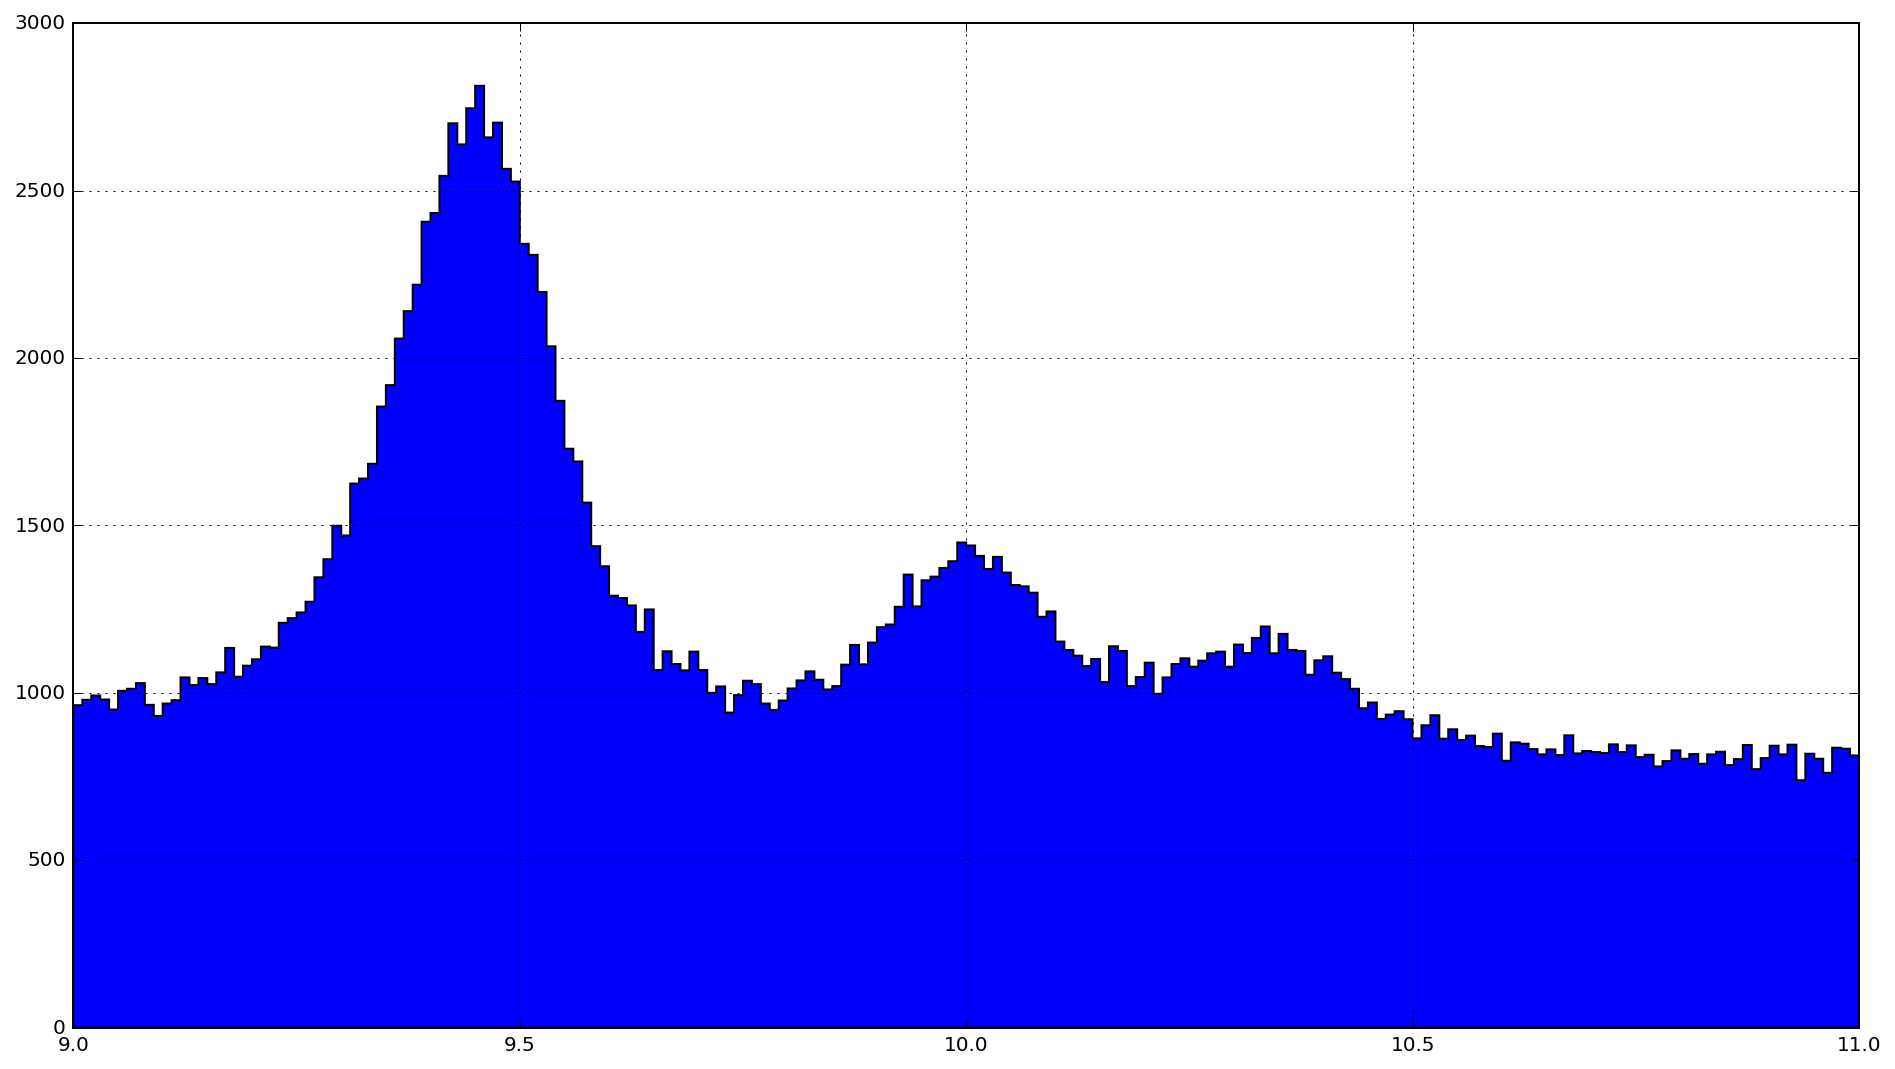

In [3]:
fig = plt.figure(num=None, figsize=(16,9), dpi=200, facecolor='w', edgecolor='k')
upsilon = df[df.M < 11]
upsilon = upsilon[upsilon.M > 9]
upsilon.M.hist(bins=200,histtype=u'stepfilled')
plt.show()

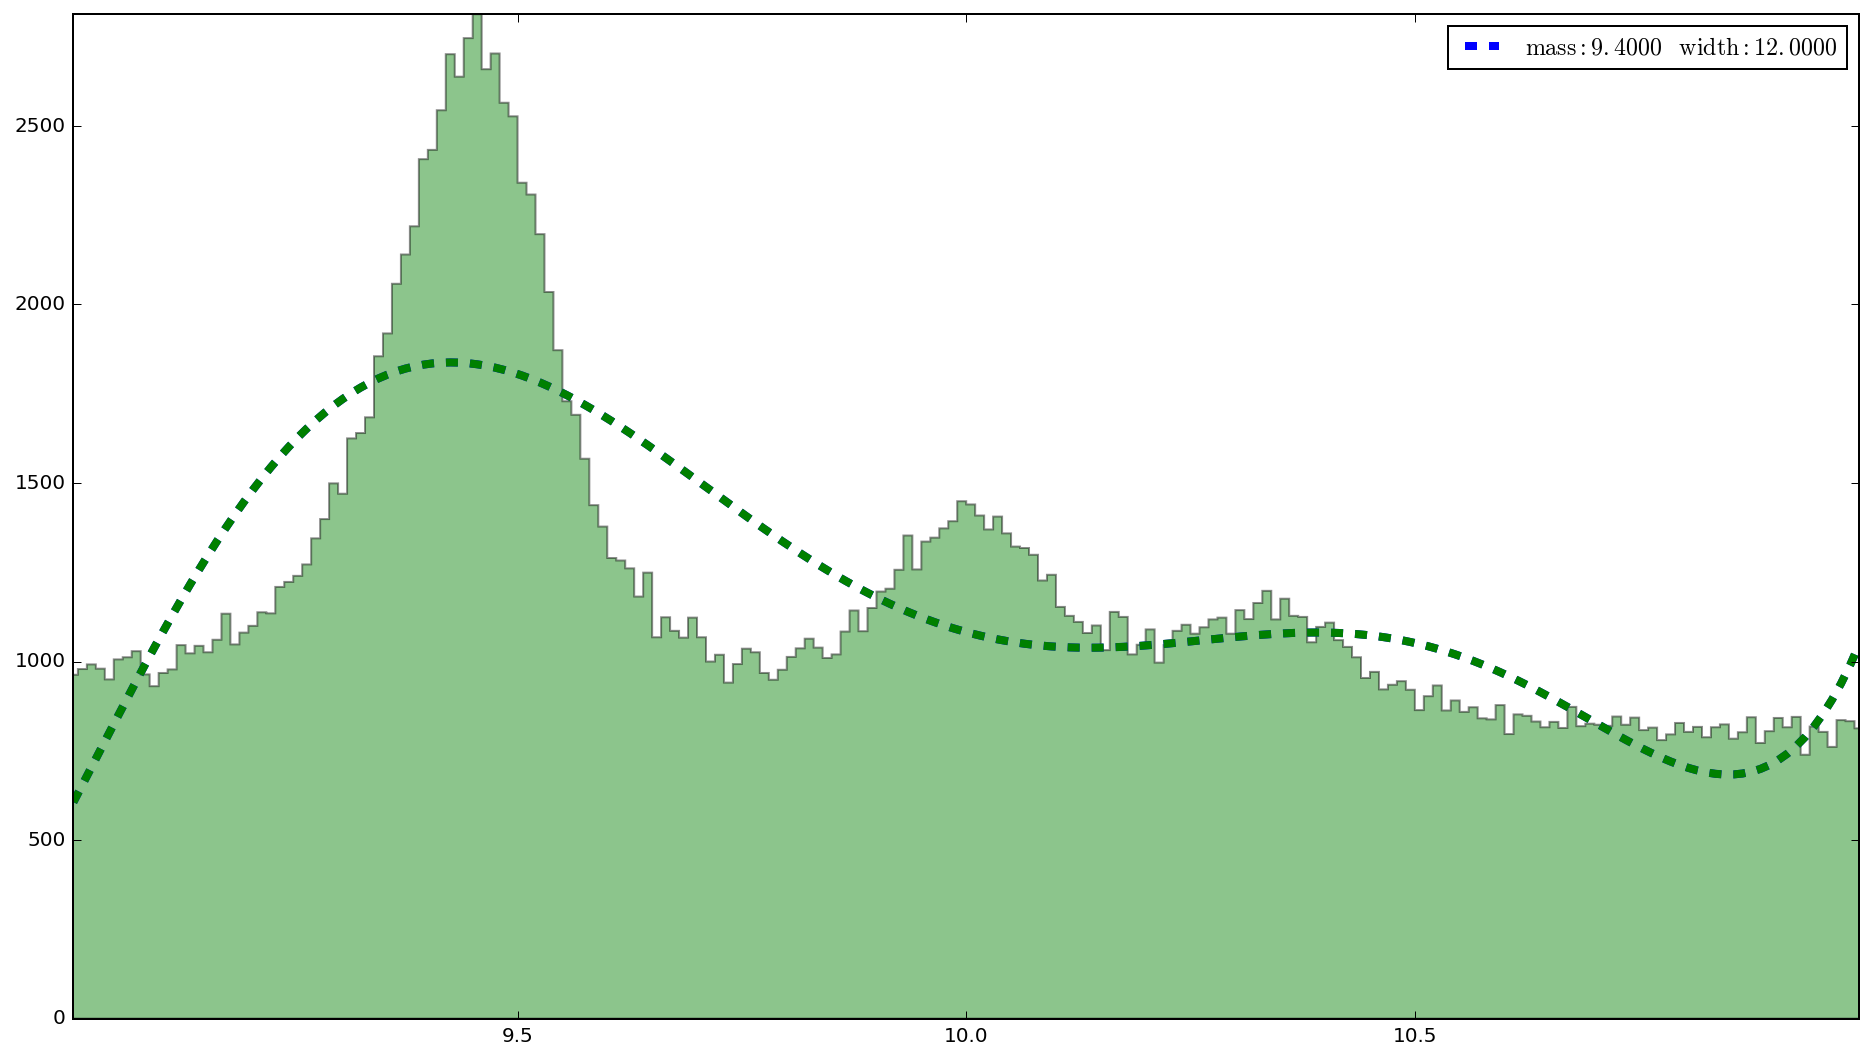

/usr/local/lib/python2.7/site-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


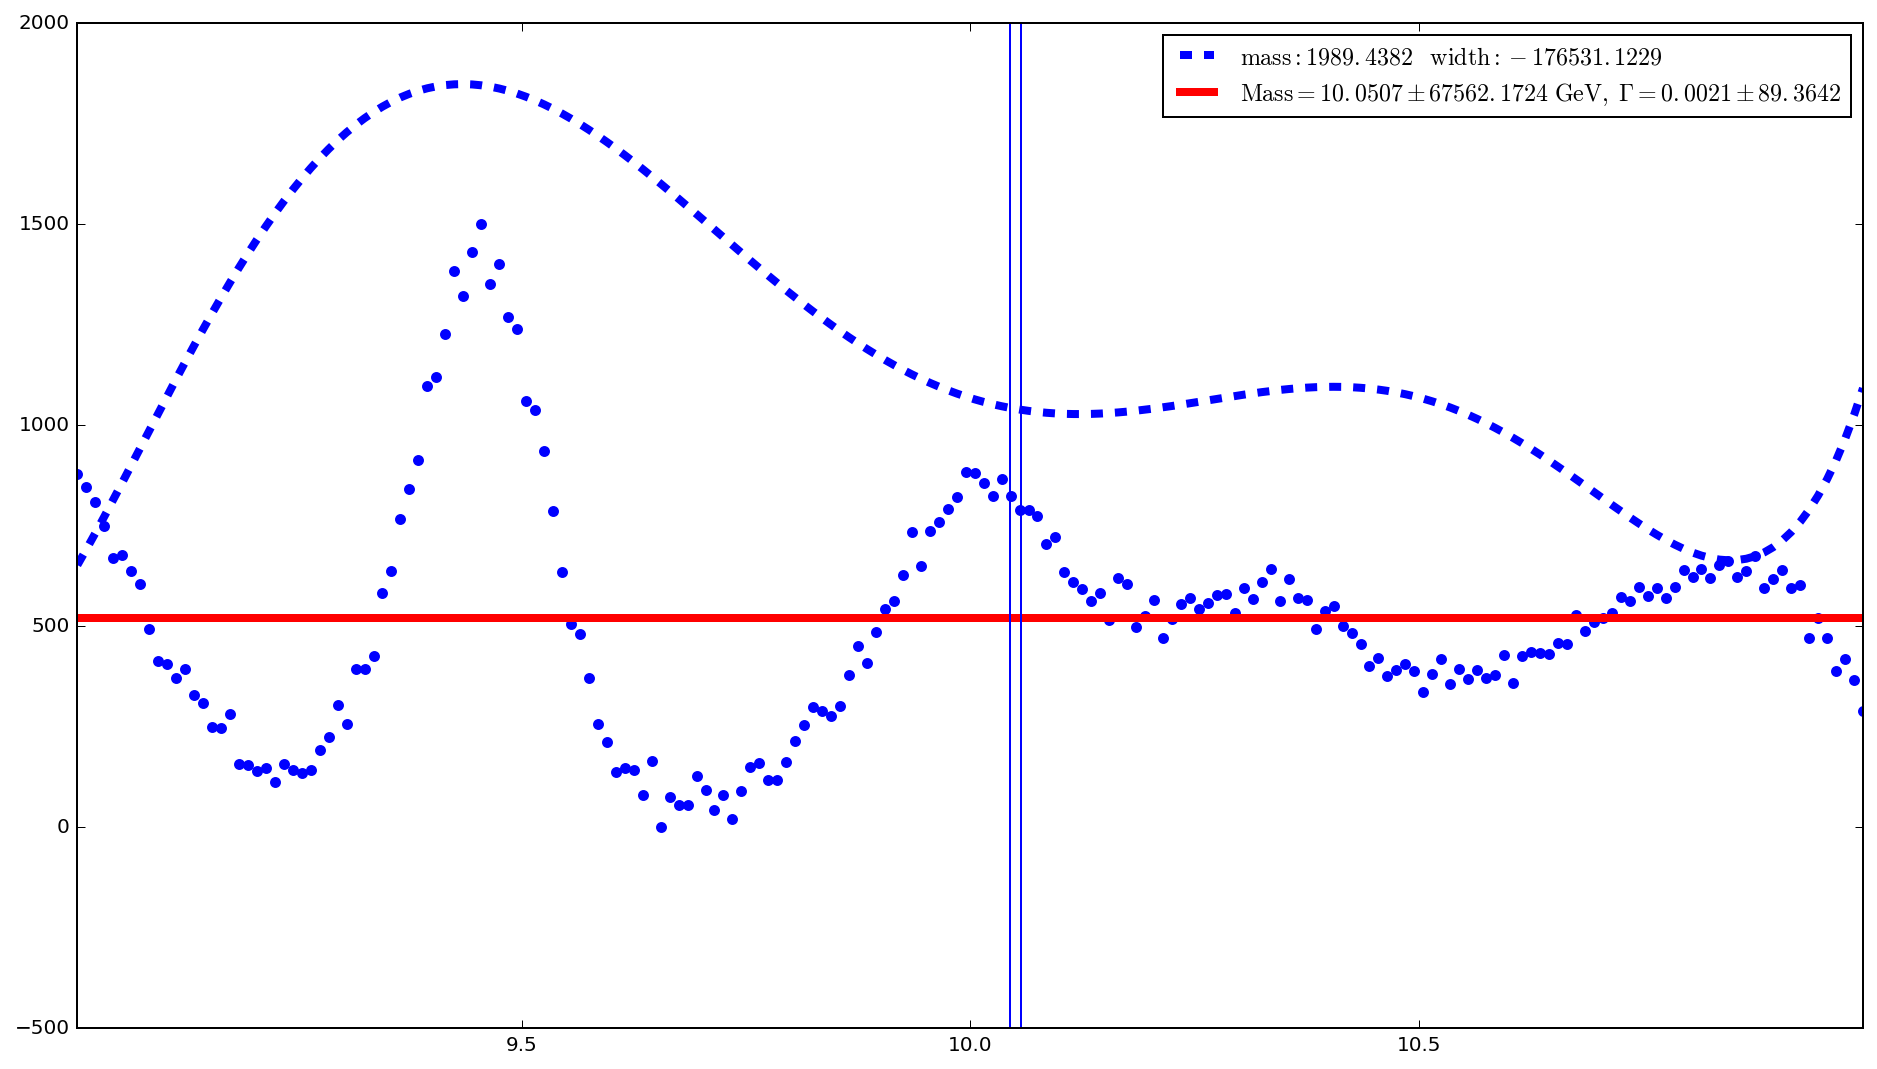

In [4]:
fig = plt.figure(num=None, figsize=(16,9), dpi=200, facecolor='w', edgecolor='k')

mass = upsilon.M

num_bins = 200

hist, bin_edges = np.histogram(mass,bins=num_bins)
xdata = 0.5*(bin_edges[1:]+bin_edges[:-1])
ydata = hist

def big_poly(x, c1, c2, c3, c4, c5, c6, c7, c8):
    #return c8*x**7 + c7*x**6 + c6*x**5 + c5*x**4 + c4*x**3 + c3*x**2 + c2*x + c1
    return c8*x**7 + c7*x**6 + c6*x**5 + c5*x**4 + c4*x**3 + c3*x**2 + c2*x + c1

def big_poly_gaus(x, mu, sig, cont, c1, c2, c3, c4, c5, c6, c7, c8):
    return gaussian(x, mu, sig, cont) + big_poly(x, c1, c2, c3, c4, c5, c6, c7, c8)

popt_1, pcov_1 = curve_fit(big_poly, xdata, ydata)

n, bins, patches = plt.hist(mass, num_bins, histtype=u'stepfilled',facecolor='g' , alpha=0.45)

x0 = np.array([9.4,12,1,popt_1[0],popt_1[1],popt_1[2],popt_1[3],popt_1[4],popt_1[5],popt_1[6],popt_1[7]])
popt_1, pcov_1 = curve_fit(big_poly_gaus, xdata, ydata,p0=x0,maxfev = 200000)

plt.plot(xdata,big_poly_gaus(xdata,*popt_1),'b--', lw=4,
        label=r'$\mathrm{mass: %.4f \: \: \: \: width: %.4f}$' %(popt_1[0],popt_1[1]))


plt.plot(xdata,big_poly(xdata,*popt_1[3:]),'g--', lw=4)
    
signal = []
for i in xrange(num_bins):
    temp = ydata[i] - big_poly(xdata[i],*popt_1[3:])
    if temp <= 0:
        temp = 0
    signal.append(temp)

#plt.scatter(xdata, signal,marker='o', color='b', label=r'$\mathrm{Signal \ points}$')

plt.ylim((0,np.max(ydata)))
plt.xlim((np.min(xdata),np.max(xdata)))
plt.legend()
plt.show()

fig = plt.figure(num=None, figsize=(16,9), dpi=200, facecolor='w', edgecolor='k')
popt_1, pcov_1 = curve_fit(big_poly_gaus, xdata, ydata,p0=x0,maxfev = 200000)

signal = []
for i in xrange(num_bins):
    temp = ydata[i] - big_poly(xdata[i],*popt_1[3:])
    signal.append(temp)

signal = np.array(signal)
signal = signal + np.abs(np.min(signal))

plt.scatter(xdata, signal,marker='o', color='b')#, label=r'$\mathrm{Signal \ points}$')

x0 = np.array([9.4,12,1,popt_1[0],popt_1[1],popt_1[2],popt_1[3],popt_1[4],popt_1[5],popt_1[6],popt_1[7]])
popt_1, pcov_1 = curve_fit(big_poly_gaus, xdata, ydata,p0=x0,maxfev = 200000)

plt.plot(xdata,big_poly_gaus(xdata,*popt_1),'b--', lw=4,
        label=r'$\mathrm{mass: %.4f \: \: \: \: width: %.4f}$' %(popt_1[0],popt_1[1]))



popt_1, pcov_1 = curve_fit(gaussian, xdata, signal,p0=[9.4,1,1],maxfev = 200000)
perr_1 = np.sqrt(np.diag(pcov_1))
plt.plot(xdata,gaussian(xdata,*popt_1),'r', lw=4,
    label=r'$\mathrm{Mass=%.4f \pm %.4f \ GeV,\ \Gamma=%.4f \pm %.4f}$' 
    %(popt_1[0], perr_1[0], popt_1[1]*(2.0*np.sqrt(2.0 * np.log(2))), perr_1[1]))

mean,width = popt_1[0],popt_1[1]
sigma = width*(2.0*np.sqrt(2.0 * np.log(2)))

plt.axvline(x=(mean - 3.0*sigma))
plt.axvline(x=(mean + 3.0*sigma))

plt.xlim((np.min(xdata),np.max(xdata)))
plt.legend(loc=0)
plt.show()

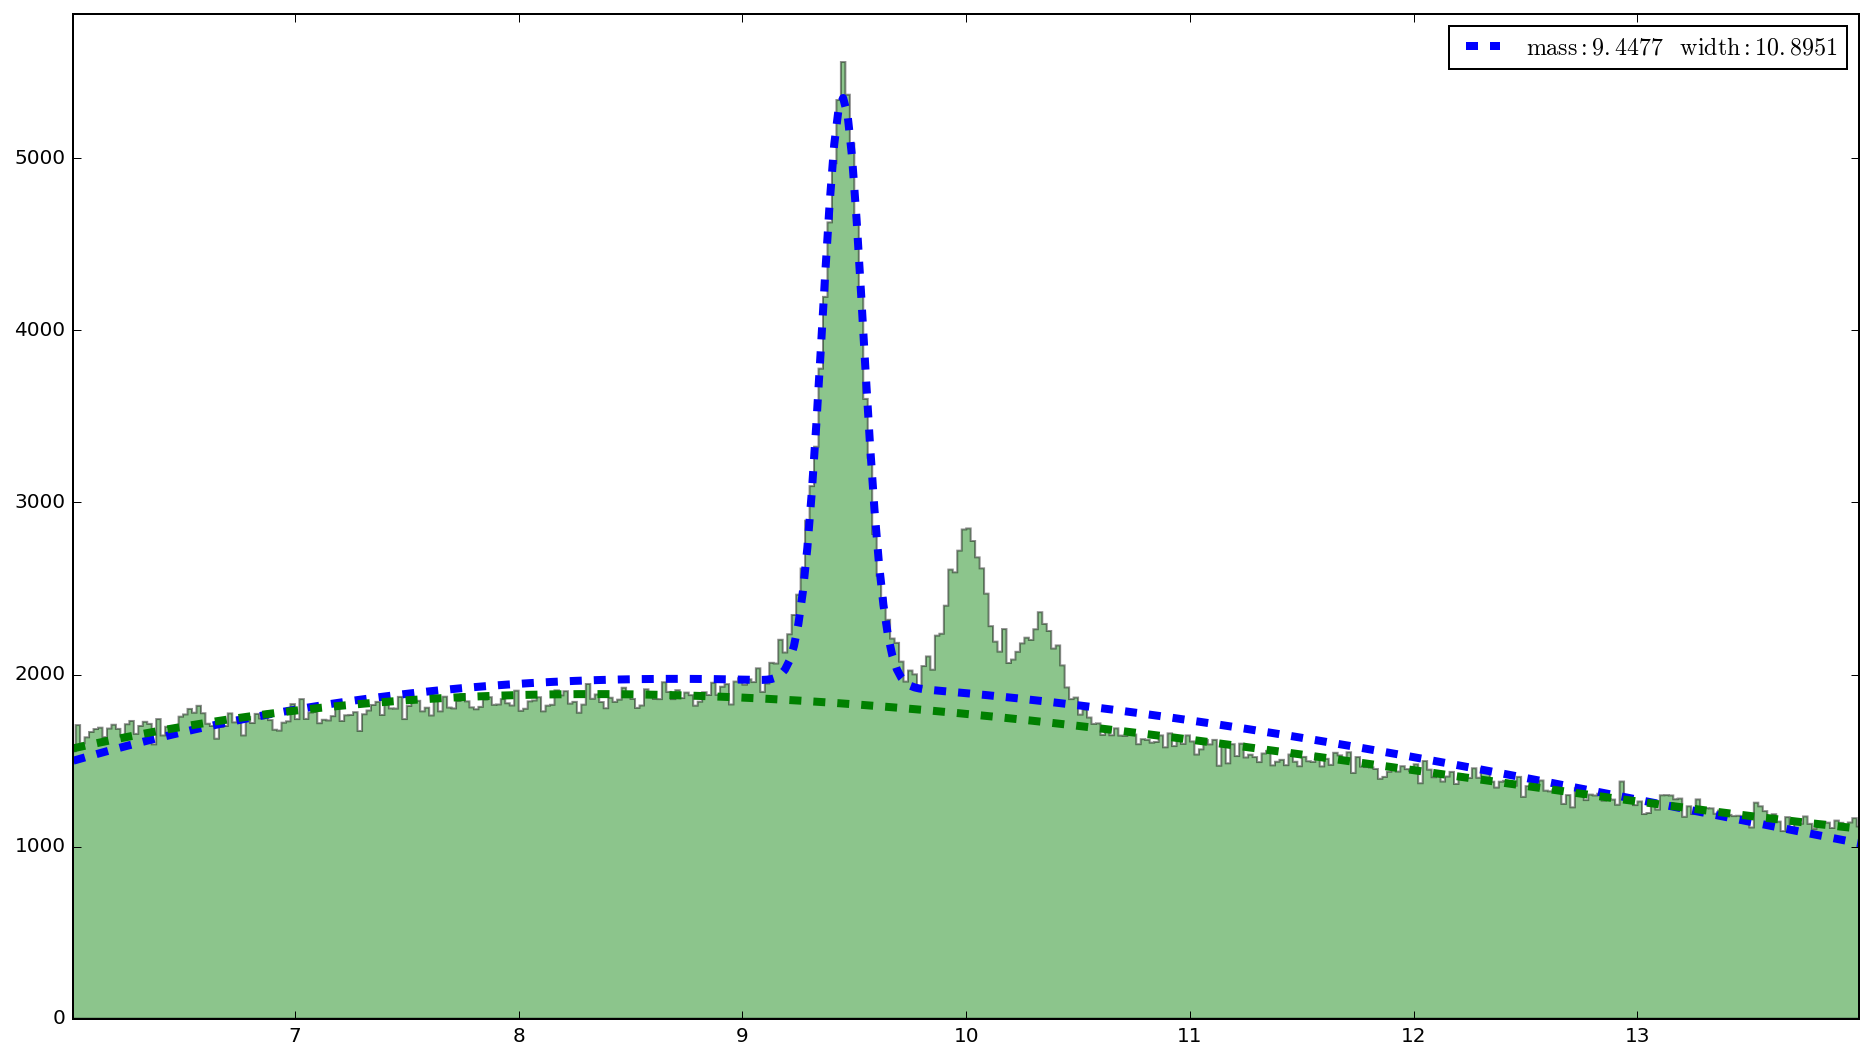

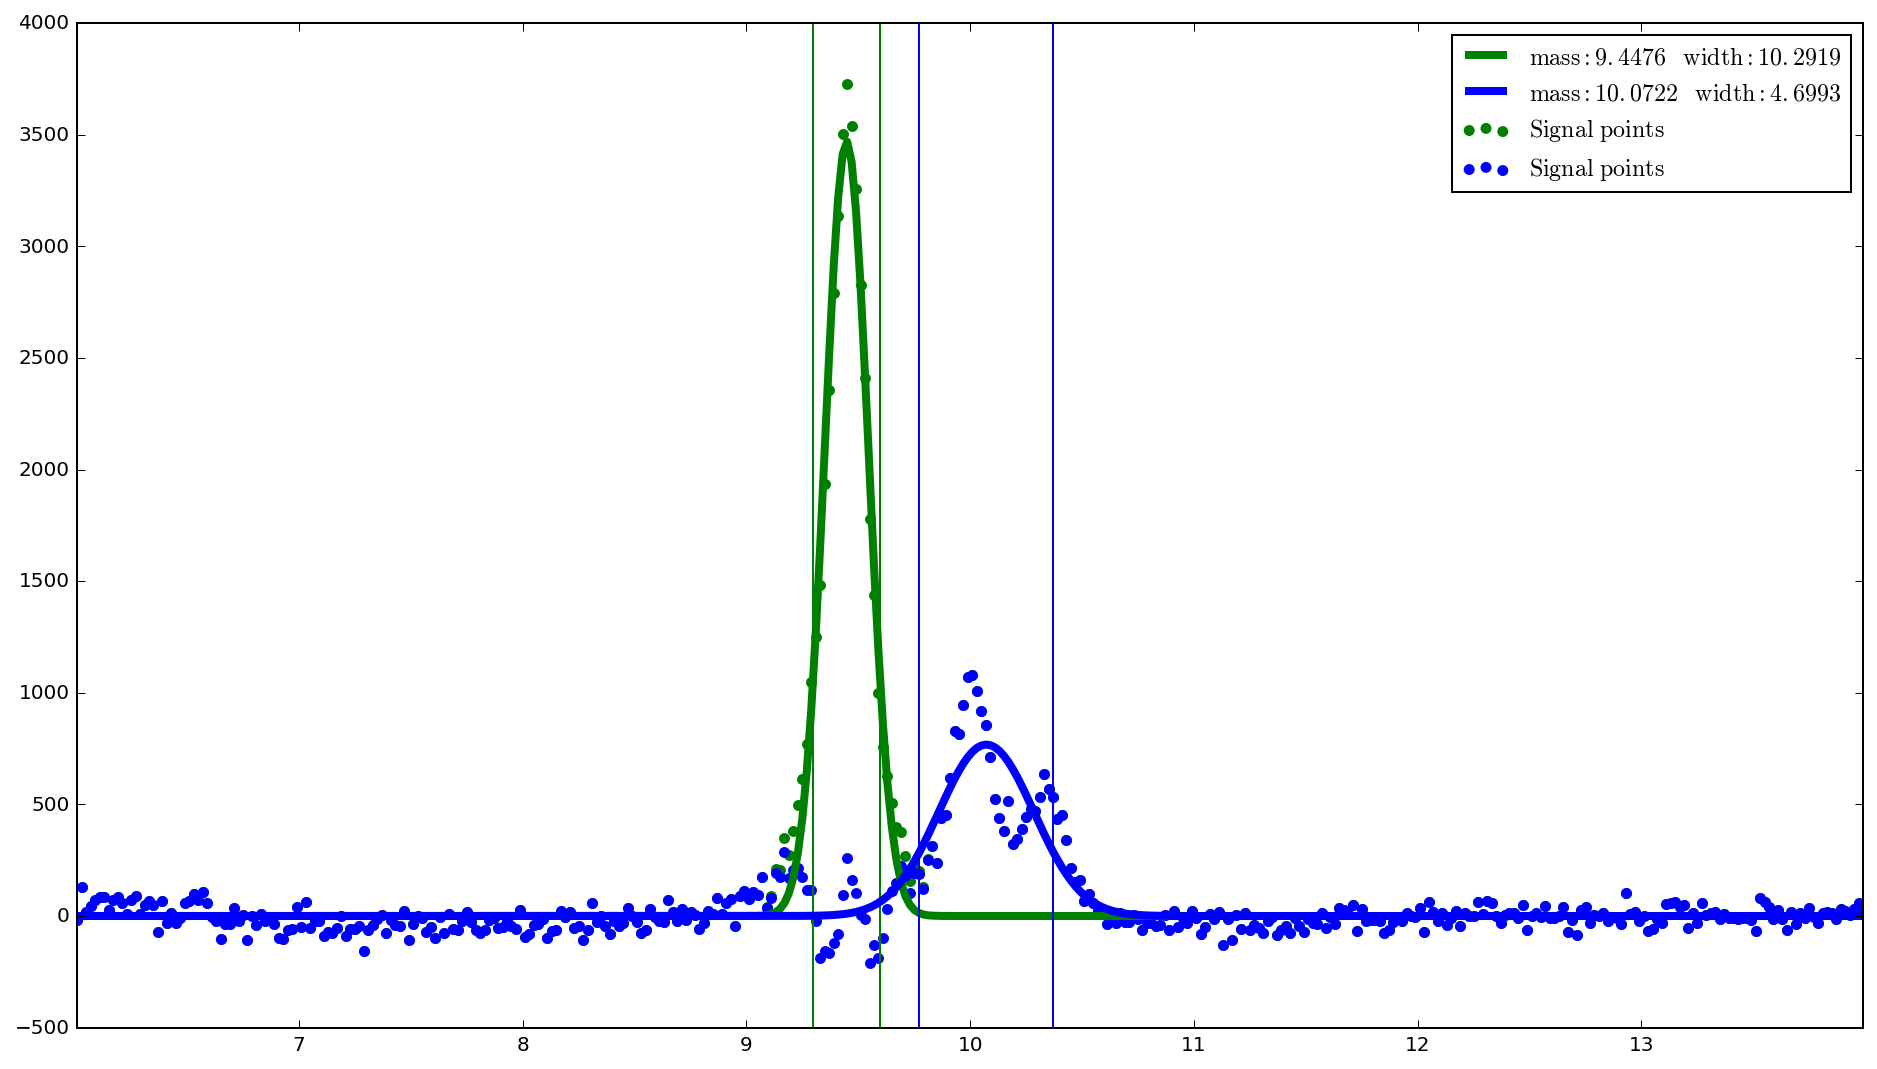

In [14]:
fig = plt.figure(num=None, figsize=(16,9), dpi=200, facecolor='w', edgecolor='k')
upsilon = df[df.M < 14]
upsilon = upsilon[upsilon.M > 6]
mass = upsilon.M

num_bins = 400

hist, bin_edges = np.histogram(mass,bins=num_bins)
xdata = 0.5*(bin_edges[1:]+bin_edges[:-1])
ydata = hist

n, bins, patches = plt.hist(mass, num_bins, histtype=u'stepfilled',facecolor='g' , alpha=0.45)

popt_1, pcov_1 = curve_fit(poly, xdata, ydata)

x0 = np.array([9.45,10.7,1,popt_1[0],popt_1[1],popt_1[2],popt_1[3]])
popt_1, pcov_1 = curve_fit(gaus_poly, xdata, ydata,p0=x0)

plt.plot(xdata,gaus_poly(xdata,*popt_1),'b--', lw=4,
        label=r'$\mathrm{mass: %.4f \: \: \: \: width: %.4f}$' %(popt_1[0],popt_1[1]))

signal_line = lambda x : gaus_poly(x,*popt_1) - poly(x, *popt_1[3:])

signal = []
for i in xrange(num_bins):
    temp = ydata[i] - signal_line(xdata[i])
    signal.append(temp)

popt_1, pcov_1 = curve_fit(poly, xdata, signal)

x0 = np.array([9.45,10.7,1,popt_1[0],popt_1[1],popt_1[2],popt_1[3]])
popt_1, pcov_1 = curve_fit(gaus_poly, xdata, signal,p0=x0,maxfev=8000)

plt.plot(xdata,poly(xdata,*popt_1[3:]),'g--', lw=4)

signal = []
for i in xrange(num_bins):
    temp = ydata[i] - poly(xdata[i],*popt_1[3:])
    signal.append(temp)

up_signal = signal
plt.ylim((0,np.max(ydata)+0.05*np.max(ydata)))
plt.xlim((np.min(xdata),np.max(xdata)))
plt.legend()
plt.show()

fig = plt.figure(num=None, figsize=(16,9), dpi=200, facecolor='w', edgecolor='k')
ydata = signal
plt.scatter(xdata,ydata,marker='o',color='g',label=r'$\mathrm{Signal \ points}$')

popt_1, pcov_1 = curve_fit(gaussian, xdata, ydata,p0=[9.45,12,1])


plt.plot(xdata,gaussian(xdata,*popt_1),'g-', lw=4,
        label=r'$\mathrm{mass: %.4f \: \: \: \: width: %.4f}$' %(popt_1[0],popt_1[1]))

mean,width = popt_1[0],popt_1[1]
sigma = 0.15/3.0 #width*(2.0*np.sqrt(2.0 * np.log(2)))
plt.axvline(x=(mean - 3.0*sigma),color='g')
plt.axvline(x=(mean + 3.0*sigma),color='g')

signal1 = []
for i in xrange(num_bins):
    temp = ydata[i] - gaussian(xdata[i],*popt_1)
    signal1.append(temp)
    
ydata = signal1
plt.scatter(xdata, signal1,marker='o', color='b', label=r'$\mathrm{Signal \ points}$')

popt_1, pcov_1 = curve_fit(gaussian, xdata, ydata, p0=[10,10.7,1],maxfev=8000)

plt.plot(xdata,gaussian(xdata,*popt_1),'b-', lw=4,
        label=r'$\mathrm{mass: %.4f \: \: \: \: width: %.4f}$' %(popt_1[0],popt_1[1]))

mean,width = popt_1[0],popt_1[1]
sigma = 0.30/3.0 #width*(2.0*np.sqrt(2.0 * np.log(2)))
plt.axvline(x=(mean - 3.0*sigma),color='b')
plt.axvline(x=(mean + 3.0*sigma),color='b')

plt.xlim((np.min(xdata),np.max(xdata)))
plt.legend()
plt.show()

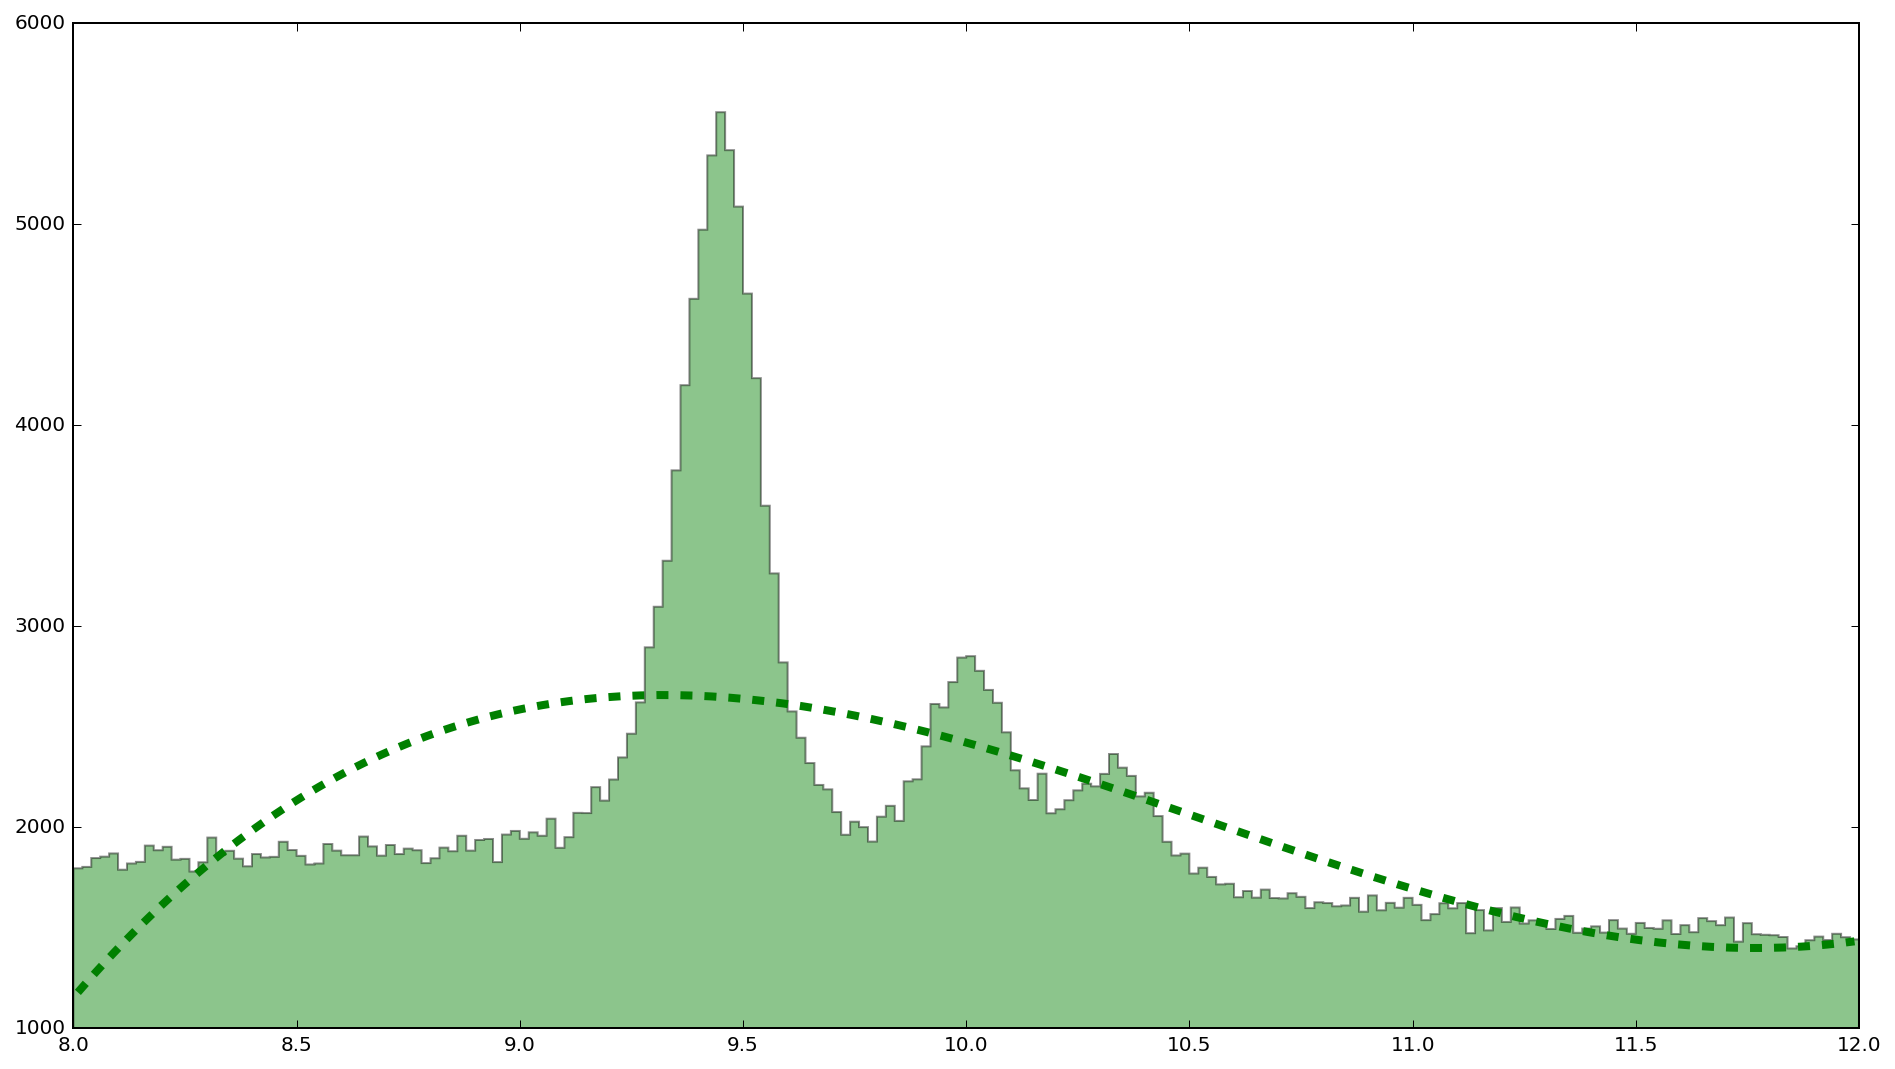

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

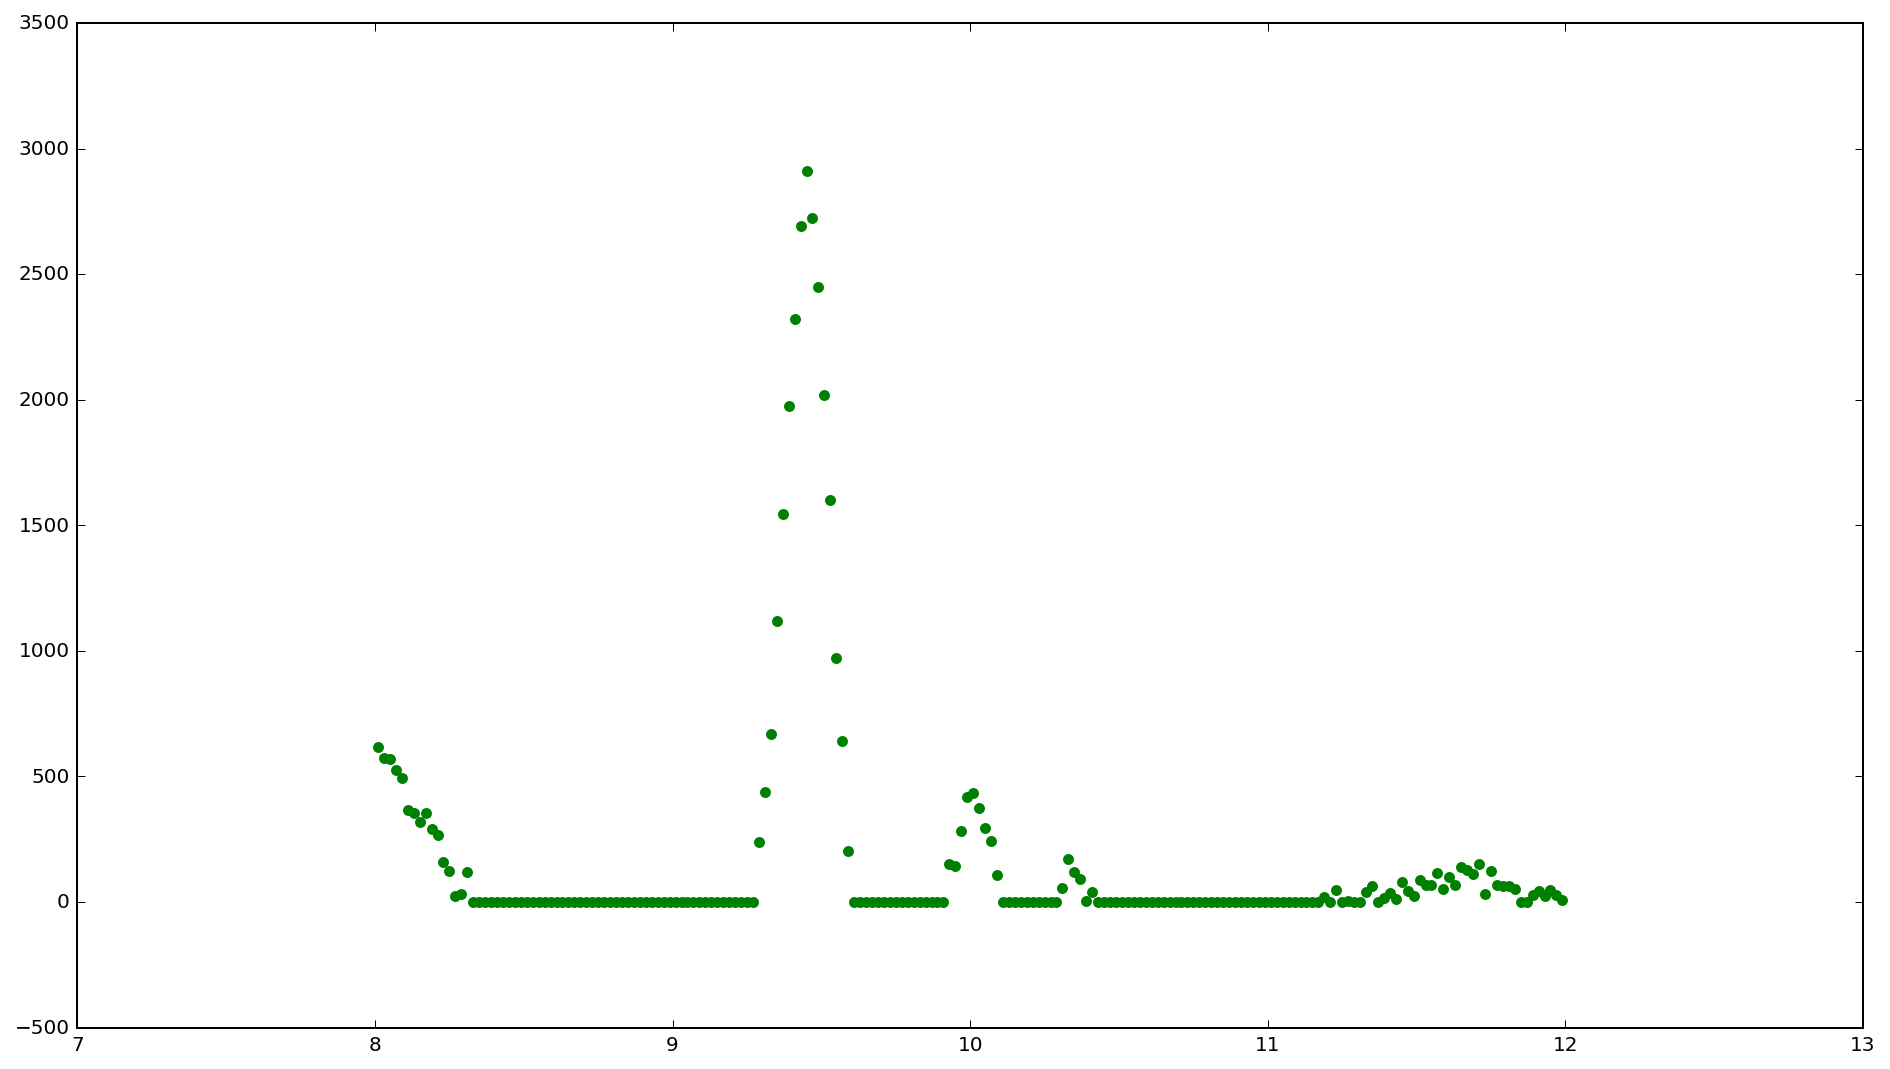

In [6]:
fig = plt.figure(num=None, figsize=(16,9), dpi=200, facecolor='w', edgecolor='k')
upsilon = df[df.M < 12]
upsilon = upsilon[upsilon.M > 8]
mass = upsilon.M

num_bins = 200

hist, bin_edges = np.histogram(mass,bins=num_bins)
xdata = 0.5*(bin_edges[1:]+bin_edges[:-1])
ydata = hist




popt_1, pcov_1 = curve_fit(poly, xdata, ydata)
x0 = np.array([9.45,10.7,1,popt_1[0],popt_1[1],popt_1[2],popt_1[3]])
popt_1, pcov_1 = curve_fit(gaus_poly, xdata, ydata,p0=x0)
signal_line = lambda x : gaus_poly(x,*popt_1) - poly(x, *popt_1[3:])

plt.hist(mass, num_bins, histtype=u'stepfilled',facecolor='g' , alpha=0.45)
plt.plot(xdata,poly(xdata,*popt_1[3:]),'g--', lw=4)
plt.show()

signal = []
for i in xrange(num_bins):
    temp = ydata[i] - signal_line(xdata[i])
    if temp <= 0:
        temp = 0
    signal.append(temp)


popt_1, pcov_1 = curve_fit(poly, xdata, signal)

x0 = np.array([9.45,10.7,1,popt_1[0],popt_1[1],popt_1[2],popt_1[3]])
popt_1, pcov_1 = curve_fit(gaus_poly, xdata, signal,p0=x0)

signal = []
for i in xrange(num_bins):
    temp = ydata[i] - poly(xdata[i],*popt_1[3:])
    if temp <= 0:
        temp = 0
    signal.append(temp)


fig = plt.figure(num=None, figsize=(16,9), dpi=200, facecolor='w', edgecolor='k')

ydata = signal
plt.scatter(xdata,ydata,marker='o',color='g')#,label=r'$\mathrm{Signal \ points}$')

popt_1, pcov_1 = curve_fit(gaussian, xdata, ydata,p0=[9.45,12,1])

perr_1 = np.sqrt(np.diag(pcov_1))
plt.plot(xdata,gaussian(xdata,*popt_1),'g', lw=4,
    label=r'$\mathrm{Mass=%.4f \pm %.4f \ GeV,\ \Gamma=%.4f \pm %.4f}$' 
    %(popt_1[0], perr_1[0], popt_1[1]*(2.0*np.sqrt(2.0 * np.log(2))), perr_1[1]))

mean,width = popt_1[0],popt_1[1]
sigma = 0.2/3.0 #width*(2.0*np.sqrt(2.0 * np.log(2)))

mean_Y = mean
sigma_Y = sigma
plt.axvline(x=(mean - 0.2),color='g')#- 3.0*sigma))
plt.axvline(x=(mean + 0.2),color='g')#+ 3.0*sigma))

signal1 = []
for i in xrange(num_bins):
    temp = ydata[i] - gaussian(xdata[i],*popt_1)
    if temp <= 0:
        temp = 0
    signal1.append(temp)
    
ydata = signal1
plt.scatter(xdata, signal1,marker='o', color='b')#, label=r'$\mathrm{Signal \ points}$')

popt_1, pcov_1 = curve_fit(gaussian, xdata, ydata, p0=[10,10.7,1],maxfev=8000)

perr_1 = np.sqrt(np.diag(pcov_1))
plt.plot(xdata,gaussian(xdata,*popt_1),'b', lw=4,
    label=r'$\mathrm{Mass=%.4f \pm %.4f \ GeV,\ \Gamma=%.4f \pm %.4f}$' 
    %(popt_1[0], perr_1[0], popt_1[1]*(2.0*np.sqrt(2.0 * np.log(2))), perr_1[1]))

mean,width = popt_1[0],popt_1[1]
sigma = 0.12/3.0 #width*(2.0*np.sqrt(2.0 * np.log(2)))
mean_Yp = mean
sigma_Yp = sigma

plt.axvline(x=(mean - 3.0*sigma),color='b')
plt.axvline(x=(mean + 3.0*sigma),color='b')


plt.ylim((0,np.max(signal)+0.05*np.max(signal)))
plt.xlim((np.min(xdata),np.max(xdata)))
plt.legend()
plt.show()

In [ ]:
Ys = df[df.M > (mean_Y - 3.0*sigma_Y)]
Ys = Ys[Ys.M < (mean_Y + 3.0*sigma_Y)]

Ys['Ypx'] = Ys.px1+Ys.px2
Ys['Ypy'] = Ys.py1+Ys.py2
Ys['Ypz'] = Ys.pz1+Ys.pz2
Ys['Ypt'] = np.sqrt(Ys.Ypx**2 + Ys.Ypy**2)
#Zs['Zpt_wrong'] = Zs.pt1+Zs.pt2
Ys['YE'] = Ys.E1+Ys.E2

fig = plt.figure(num=None, figsize=(16,9), dpi=200, facecolor='w', edgecolor='k')
plt.hist(Ys.Ypt, 100, histtype=u'stepfilled',facecolor='g' , alpha=0.45)

#fig = plt.figure(num=None, figsize=(16,9), dpi=200, facecolor='w', edgecolor='k')
plt.hist(Ys.Ypz, 100, histtype=u'stepfilled',facecolor='b' , alpha=0.45)

#fig = plt.figure(num=None, figsize=(16,9), dpi=200, facecolor='w', edgecolor='k')
plt.hist(Ys.YE, 100, histtype=u'stepfilled',facecolor='r' , alpha=0.45)

plt.show()

In [ ]:
temp = Ys.drop(['Event','Run','Type1','Type2'],axis=1)
temp = temp.drop(['E1','px1','py1','pz1','pt1','eta1','phi1','Q1'],axis=1)
temp = temp.drop(['E2','px2','py2','pz2','pt2','eta2','phi2','Q2'],axis=1)

ax = scatter_matrix(temp, alpha=0.1, figsize=(20, 15),diagonal='kde')
temp.describe()

In [ ]:
fig = plt.figure(num=None, figsize=(16,9), dpi=200, facecolor='w', edgecolor='k')
temp = Ys#[Zs.Zpt < 120]
#temp = temp[temp.Zpt > -120]
#temp = temp[temp.Zpz > -200]
#temp = temp[temp.Zpz < 200]
plt.hist2d(temp.Ypz,temp.YE,bins=200,cmap='viridis')
plt.colorbar()
plt.show()

In [ ]:
fig = plt.figure(num=None, figsize=(16,9), dpi=200, facecolor='w', edgecolor='k')
temp = Ys[Ys.Ypt < 30]
temp = temp[temp.YE < 50]
#temp = temp[temp.Zpz > -200]
#temp = temp[temp.Zpz < 200]
plt.hist2d(temp.YE,temp.Ypt,bins=250,cmap='viridis')#,norm=LogNorm())
plt.colorbar()
plt.show()

In [ ]:
Yps = df[df.M > (mean_Yp - 3.0*sigma_Yp)]
Yps = Yps[Yps.M < (mean_Yp + 3.0*sigma_Yp)]

Yps['Yppx'] = Yps.px1+Yps.px2
Yps['Yppy'] = Yps.py1+Yps.py2
Yps['Yppz'] = Yps.pz1+Yps.pz2
Yps['Yppt'] = np.sqrt(Yps.Yppx**2 + Yps.Yppy**2)
Yps['YpE'] = Yps.E1+Yps.E2

fig = plt.figure(num=None, figsize=(16,9), dpi=200, facecolor='w', edgecolor='k')
plt.hist(Yps.Yppt, 100, histtype=u'stepfilled',facecolor='g' , alpha=0.45)

#fig = plt.figure(num=None, figsize=(16,9), dpi=200, facecolor='w', edgecolor='k')
plt.hist(Yps.Yppz, 100, histtype=u'stepfilled',facecolor='b' , alpha=0.45)

#fig = plt.figure(num=None, figsize=(16,9), dpi=200, facecolor='w', edgecolor='k')
plt.hist(Yps.YpE, 100, histtype=u'stepfilled',facecolor='r' , alpha=0.45)

plt.show()

In [ ]:
temp = Yps.drop(['Event','Run','Type1','Type2'],axis=1)
temp = temp.drop(['E1','px1','py1','pz1','pt1','eta1','phi1','Q1'],axis=1)
temp = temp.drop(['E2','px2','py2','pz2','pt2','eta2','phi2','Q2'],axis=1)

ax = scatter_matrix(temp, alpha=0.1, figsize=(20, 15),diagonal='kde')
temp.describe()

In [ ]:
fig = plt.figure(num=None, figsize=(16,9), dpi=200, facecolor='w', edgecolor='k')
temp = Yps[Yps.Yppt < 30]
temp = temp[temp.YpE < 50]
#temp = temp[temp.Zpz > -200]
#temp = temp[temp.Zpz < 200]
plt.hist2d(temp.YpE,temp.Yppt,bins=250,cmap='viridis')#,norm=LogNorm())
plt.colorbar()
plt.show()

In [ ]:
fig = plt.figure(num=None, figsize=(16,9), dpi=200, facecolor='w', edgecolor='k')

plt.hist(mass, 200, histtype=u'stepfilled',facecolor='g' , alpha=0.45)

plt.axvline(x=(mean_Y - 3.0*sigma_Y),color='b')
plt.axvline(x=(mean_Y + 3.0*sigma_Y),color='b')

plt.axvline(x=(mean_Yp - 3.0*sigma_Yp),color='r')
plt.axvline(x=(mean_Yp + 3.0*sigma_Yp),color='r')


plt.xlim(8,12)
plt.show()

In [ ]:
both = pd.DataFrame()
both['E'] = np.append(Ys.YE,Yps.YpE)
both['Px'] = np.append(Ys.Ypx,Yps.Yppx)
both['Py'] = np.append(Ys.Ypy,Yps.Yppy)
both['Pz'] = np.append(Ys.Ypz,Yps.Yppz)
both['Pt'] = np.append(Ys.Ypt,Yps.Yppt)
both['M'] = np.append(Ys.M,Yps.M)
both.describe()

In [ ]:
ax = scatter_matrix(both, alpha=0.1, figsize=(20, 15),diagonal='kde')

In [ ]:
fig = plt.figure(num=None, figsize=(16,9), dpi=200, facecolor='w', edgecolor='k')
temp = both[both.Pt < 30]
temp = temp[temp.E < 50]
#temp = temp[temp.Zpz > -200]
#temp = temp[temp.Zpz < 200]
plt.hist2d(temp.E,temp.Pt,bins=250,cmap='viridis')#,norm=LogNorm())
plt.colorbar()
plt.show()

In [ ]:
fig = plt.figure(num=None, figsize=(16,9), dpi=200, facecolor='w', edgecolor='k')
temp = pd.DataFrame()
temp['Px'] = df.px1+df.px2
temp['Py'] = df.py1+df.py2
temp['Pz'] = df.pz1+df.pz2
temp['Pt'] = np.sqrt(np.square(df.px1) + np.square(df.px2))
temp['E'] = df.E1+df.E2
temp['M'] = df.M

temp = temp[temp.Pt < 130]
temp = temp[temp.E < 160]
temp = temp[temp.M > 40]

plt.hist2d(temp.M,temp.Pt,bins=500,cmap='viridis')#,norm=LogNorm())
plt.colorbar()
plt.show()